In [82]:
import pandas as pd

In [83]:
peaks = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/intersect.merged.bed", sep="\t")

In [84]:
gm="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/GM12878/ATAC/GM12878_w_bias.bw"
hep="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/HEPG2/ATAC/HEPG2_w_bias.bw"
imr="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/IMR90/ATAC/IMR90_w_bias.bw"
h1="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/H1ESC/ATAC/H1ESC_w_bias.bw"
k5="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/K562/ATAC/K562_w_bias.bw"


In [85]:
import pyBigWig as pw

In [86]:
gm_bw = pw.open(gm)
hep_bw = pw.open(hep)
imr_bw = pw.open(imr)
h1_bw = pw.open(h1)
k5_bw = pw.open(k5)

In [87]:
import numpy as np
def fetch_singal(peaks_in, data_in, norm):
    values = []
    for i,r in peaks_in.iterrows():
        values.append(np.sum(np.nan_to_num(data_in.values(r[0],r[1],r[2]))/norm))
    return values

In [88]:
out_gm = fetch_singal(peaks, gm_bw, 572)

In [89]:
out_hep = fetch_singal(peaks, hep_bw, 592)
out_imr = fetch_singal(peaks, imr_bw, 104)
out_h1 = fetch_singal(peaks, h1_bw, 150)
out_k5 = fetch_singal(peaks, k5_bw, 546)

In [90]:
data_full = pd.DataFrame({"GM12878":out_gm,"HEPG2":out_hep,"IMR90":out_imr,"H1ESC":out_h1,"K562":out_k5})

In [91]:
matrix_n=np.array([out_gm,out_hep,out_imr,out_h1,out_k5]).transpose()

In [92]:
matrix_n.shape

(38948, 5)

In [93]:
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats

def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds, cluster_assignments

In [105]:
cluster_assignments, inds = cluster_matrix_indices(matrix_n,5)

# Plot the heatmap
# defining light source
#ls = mcolors.LightSource()

#hmap = ax.imshow(coop_matrix[inds][:,inds,:])

In [106]:
import matplotlib.pyplot as plt

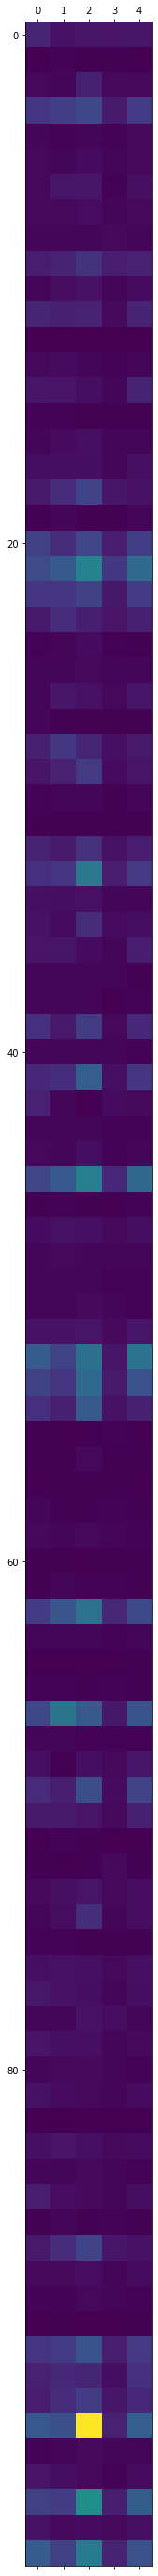

In [107]:
fig, ax = plt.subplots(figsize=(10, 50))
hmap = ax.matshow(matrix_n[cluster_assignments][np.random.choice(np.arange(matrix_n.shape[0]),100)])
plt.show()

In [112]:
peaks[inds==4]


,chr1,181394,181550
3,chr1,778468,779245
18,chr1,999996,1001029
22,chr1,1019247,1020341
33,chr1,1273512,1274515
35,chr1,1307893,1308764
...,...,...,...
38926,chrX,154804988,154805901
38929,chrX,155026555,155027570
38932,chrX,155070730,155071945
38934,chrX,155215955,155217030


In [113]:
peaks.shape

(38948, 3)

In [116]:
main_dir="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/"
hep_hits = pd.read_csv(main_dir+"hepg2_hits.in.intersect.bed", sep="\t", header=None)
hep_hits[10] = 'HEPG2'
gm_hits = pd.read_csv(main_dir+"gm_hits.in.intersect.bed", sep="\t", header=None)
gm_hits[10] = 'GM12878'

k5_hits = pd.read_csv(main_dir+"k562_hits.in.intersect.bed", sep="\t", header=None)
k5_hits[10] = "K562"
h1_hits = pd.read_csv(main_dir+"h1_hits.in.intersect.bed", sep="\t", header=None)
h1_hits[10] = "H1"

In [117]:
merged = pd.concat([hep_hits,gm_hits,k5_hits,h1_hits])

In [119]:
merged.to_csv(main_dir+"merged_hits.intersec.bed",sep="\t",header=False,index=False)

In [121]:
data = pd.read_csv(main_dir+"merged_hits.intersec.cluster.bed",sep="\t",header=None)

In [123]:
len(set(data[11]))

82299

In [173]:
for i in range(1,82299):
    data_sub = data[data[11]==i]
    if set(['K562', 'H1', 'HEPG2', 'GM12878']) == set(data_sub[10]):
        gm_hits = data_sub[data_sub[10]=="GM12878"].drop_duplicates()[3].str.split("_",-1).str[2].values
        hep_hits = data_sub[data_sub[10]=="HEPG2"].drop_duplicates()[3].str.split("_",-1).str[2].values
        k5_hits = data_sub[data_sub[10]=="K562"].drop_duplicates()[3].str.split("_",-1).str[2].values
        h1_hits = data_sub[data_sub[10]=="H1"].drop_duplicates()[3].str.split("_",-1).str[2].values

        if (len(gm_hits)==1) and (gm_hits.all() == k5_hits.all()) and (gm_hits.all() == h1_hits.all())  and (gm_hits.all() == hep_hits.all()) and (len(hep_hits) > len(gm_hits)):
            if ("HNF4G" in hep_hits):
                print(data_sub)
                print(gm_hits,hep_hits,k5_hits,h1_hits)
    else:
        continue
    

        0        1        2                   3  4          5    6   \
1605  chr1  6720157  6720169  0_1_HNF4G_MA0484.1  -   4.507312  900   
1606  chr1  6720167  6720181   0_0_CTCF_MA0139.1  -  12.291785  900   
1607  chr1  6720167  6720181   0_1_CTCF_MA0139.1  +  12.264583  961   
1608  chr1  6720167  6720180   0_1_CTCF_MA0139.1  +  12.496766  528   
1609  chr1  6720167  6720181   0_0_CTCF_MA0139.1  -  12.176380  453   

             7     8         9        10   11  
1605   5.463794  1353  0.007184    HEPG2  361  
1606  16.961133  1353  0.037469    HEPG2  361  
1607   8.841119  1323  0.020948     K562  361  
1608  15.336946  1106  0.033061  GM12878  361  
1609  22.725498   556  0.054949       H1  361  
['CTCF'] ['HNF4G' 'CTCF'] ['CTCF'] ['CTCF']
        0         1         2                   3  4          5     6   \
3990  chr1  17661740  17661752  0_1_HNF4G_MA0484.1  -   5.485211  2423   
3991  chr1  17661750  17661763   0_1_CTCF_MA0139.1  +  10.934680  1673   
3992  chr1  1766175

          0         1         2                   3  4          5      6   \
35142  chr10  30581958  30581970  0_1_HNF4G_MA0484.1  -   4.959944  21376   
35143  chr10  30581968  30581981   0_1_CTCF_MA0139.1  +  10.556849  20612   
35144  chr10  30581968  30581982   0_0_CTCF_MA0139.1  -  11.432909  18720   
35145  chr10  30581968  30581982   0_1_CTCF_MA0139.1  +  11.466774  27125   
35146  chr10  30581968  30581982   0_0_CTCF_MA0139.1  -  11.641200  21376   

              7      8         9        10    11  
35142   6.612934  37048  0.009369    HEPG2  9325  
35143  18.750223  41969  0.042138  GM12878  9325  
35144  23.469052  26868  0.054302       H1  9325  
35145  10.916379  32055  0.023064     K562  9325  
35146  14.344784  37048  0.028102    HEPG2  9325  
['CTCF'] ['HNF4G' 'CTCF'] ['CTCF'] ['CTCF']
          0          1          2                   3  4          5      6   \
43549  chr10  104350336  104350348  0_1_HNF4G_MA0484.1  -   7.251801  27282   
43550  chr10  104350353  1043

          0         1         2                   3  4         5      6   \
88834  chr14  34365470  34365482  0_1_HNF4G_MA0484.1  -  7.738108  56717   
88835  chr14  34365480  34365494   0_0_CTCF_MA0139.1  -  9.453849  56717   
88836  chr14  34365480  34365493   0_1_CTCF_MA0139.1  +  8.521606  53647   
88837  chr14  34365480  34365494   0_1_CTCF_MA0139.1  +  9.257467  60599   
88838  chr14  34365480  34365494   0_0_CTCF_MA0139.1  -  9.489919  50560   

             7       8         9        10     11  
88834  7.213279   98557  0.017597    HEPG2  22997  
88835  8.555887   98557  0.021254    HEPG2  22997  
88836  9.356890  109305  0.020394  GM12878  22997  
88837  4.890904   75515  0.008446     K562  22997  
88838  9.082928   73878  0.016098       H1  22997  
['CTCF'] ['HNF4G' 'CTCF'] ['CTCF'] ['CTCF']
          0         1         2                   3  4          5      6   \
90015  chr14  51283476  51283488  0_1_HNF4G_MA0484.1  -   5.622004  58321   
90016  chr14  51283486  51283500 

          0          1          2                   3  4         5       6   \
184743  chr2  203484422  203484434  0_1_HNF4G_MA0484.1  -  6.223630  121761   
184744  chr2  203484432  203484446   0_1_CTCF_MA0139.1  +  8.934674  115630   
184745  chr2  203484432  203484445   0_1_CTCF_MA0139.1  +  9.429550  102726   
184746  chr2  203484432  203484446   0_0_CTCF_MA0139.1  -  9.386026  121761   
184747  chr2  203484432  203484446   0_0_CTCF_MA0139.1  -  9.141944   94197   

              7       8         9        10     11  
184743  4.621912  208219  0.006571    HEPG2  46787  
184744  8.073854  149226  0.015325     K562  46787  
184745  5.463571  211923  0.011749  GM12878  46787  
184746  9.122750  208219  0.014747    HEPG2  46787  
184747  5.369564  137696  0.011598       H1  46787  
['CTCF'] ['HNF4G' 'CTCF'] ['CTCF'] ['CTCF']
          0          1          2                   3  4          5       6   \
185348  chr2  211455411  211455423  0_1_HNF4G_MA0484.1  -   5.057939  122466   
185

          0          1          2                          3  4          5   \
236257  chr4  145154736  145154743  0_2_FOXM1_HUMAN.H11MO.0.A  +   6.407177   
236258  chr4  145154752  145154764         0_1_HNF4G_MA0484.1  -   6.223630   
236259  chr4  145154762  145154775          0_1_CTCF_MA0139.1  +  10.223427   
236260  chr4  145154762  145154776          0_0_CTCF_MA0139.1  -   9.693149   
236261  chr4  145154762  145154776          0_0_CTCF_MA0139.1  -   9.747657   
236262  chr4  145154762  145154776          0_1_CTCF_MA0139.1  +   9.345045   

            6          7       8         9        10     11  
236257  163049   4.757983  277360  0.009399    HEPG2  60117  
236258  163049   5.715855  277361  0.008251    HEPG2  60117  
236259  137601   6.661144  282805  0.016941  GM12878  60117  
236260  163049  16.705284  277361  0.027861    HEPG2  60117  
236261  127671  23.319112  186888  0.047658       H1  60117  
236262  152259   6.887149  194830  0.013563     K562  60117  
['CTCF'] ['F

          0         1         2                    3  4          5       6   \
305307  chr9  99184734  99184742  0_14_ESRRB_MA0141.3  +   4.142493  215391   
305308  chr9  99184741  99184753   0_1_HNF4G_MA0484.1  -   4.937659  215391   
305309  chr9  99184766  99184780    0_0_CTCF_MA0139.1  +   2.845091  215391   
305310  chr9  99184780  99184794    0_0_CTCF_MA0139.1  -  10.853542  180470   
305311  chr9  99184780  99184794    0_0_CTCF_MA0139.1  -  10.772366  215391   
305312  chr9  99184780  99184793    0_1_CTCF_MA0139.1  +  12.203440  188224   
305313  chr9  99184780  99184794    0_1_CTCF_MA0139.1  +  10.795618  207260   

               7       8         9        10     11  
305307   9.126165  367829  0.015375    HEPG2  78310  
305308   4.181408  367829  0.006795    HEPG2  78310  
305309   4.482258  367830  0.006784    HEPG2  78310  
305310  18.261623  264576  0.043060       H1  78310  
305311  17.374581  367830  0.031827    HEPG2  78310  
305312  16.477093  384643  0.035784  GM1287

In [125]:
data

,0,1,2,3,4,5,6,7,8,9,10,11
0,chr1,268001,268014,0_1_CTCF_MA0139.1,+,10.400685,2,18.083610,2,0.043896,GM12878,1
1,chr1,268001,268015,0_0_CTCF_MA0139.1,-,10.161144,1,20.767595,2,0.050104,H1,1
2,chr1,268001,268015,0_1_CTCF_MA0139.1,+,10.151170,16,18.146775,24,0.041662,K562,1
3,chr1,268002,268015,0_35_CTCFL_MA1102.1,-,4.188651,4,19.766597,6,0.040889,HEPG2,1
4,chr1,268014,268025,0_20_JUN_MA0488.1,-,6.013082,16,6.066852,24,0.006714,K562,1
...,...,...,...,...,...,...,...,...,...,...,...,...
321254,chrX,156016884,156016894,0_11_NRF1_MA0506.1,-,5.183921,224563,6.231672,384161,0.014581,HEPG2,82299
321255,chrX,156016890,156016904,0_1_CTCF_MA0139.1,-,11.691064,217062,18.014884,273658,0.042489,K562,82299
321256,chrX,156016890,156016904,0_0_CTCF_MA0139.1,+,11.278510,188597,16.307169,277172,0.042058,H1,82299
321257,chrX,156016891,156016904,0_1_CTCF_MA0139.1,-,10.707404,197736,16.195086,404555,0.036051,GM12878,82299
